# Vanilla PCA for Image Denoising

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from skimage import io
import tensorflow as tf
import matplotlib.patches as mpatches
#import skimage.measure as measure
import skimage.metrics as measure
import math
import cv2

# Denoising in MNIST digit dataset using PCA


In [3]:
# load the digit dataset
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

## Visualize the data

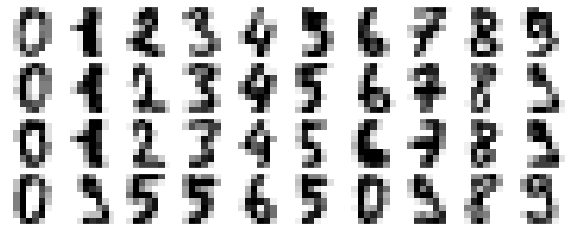

In [70]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)
#print(digits.data)

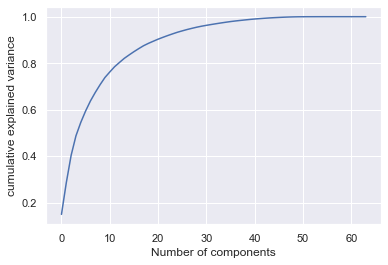

In [76]:
# Number of components needed to describe the data. From the figure we can observe that first 10 components we are able
# to recover 80 of the variance in the data.
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('cumulative explained variance');

## Add random Gaussian noise to this dataset

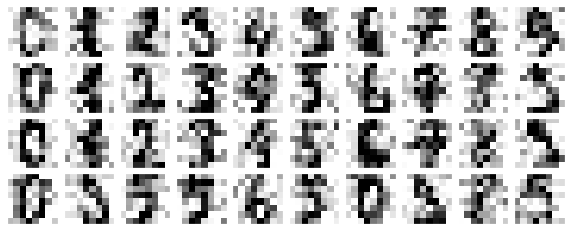

In [71]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

It's clear by eye that the images are noisy, and contain spurious pixels. Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

## Analyze number of components to retrieve 50 per of Variance

In [72]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Here 50% of the variance amounts to 12 principal components. Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

## Visualize these principal components

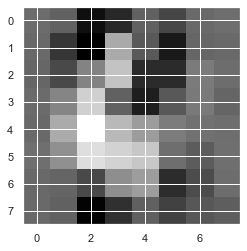

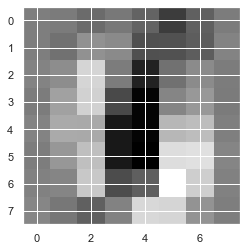

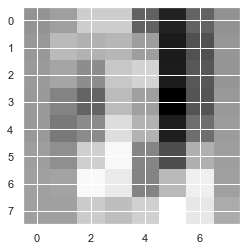

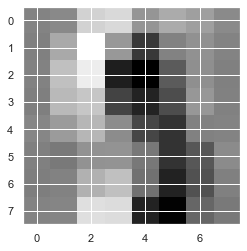

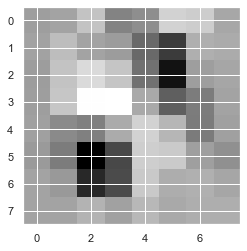

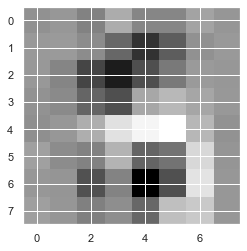

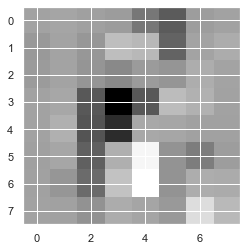

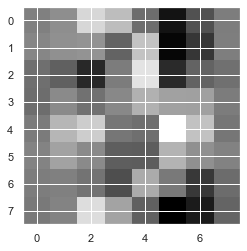

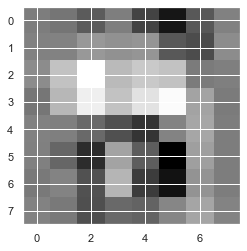

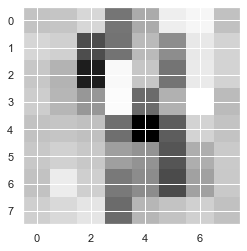

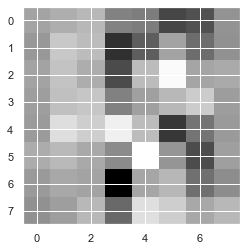

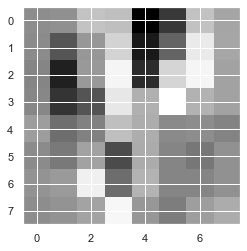

In [73]:
for co in pca.components_:
  plt.imshow(co.reshape(8,8),cmap="gray")
  plt.show()

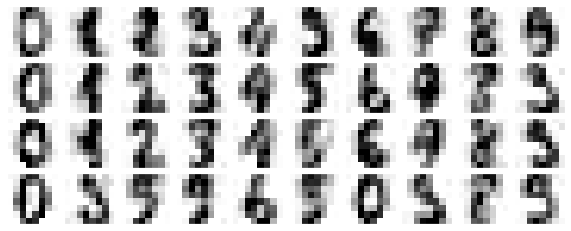

In [74]:
## DO PCA transformation and inverse transformation
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

# Vanilla PCA in a RGB image for Denoising

In [65]:
###
# Method takes original image, and add noise to it and do pca analysis
###
def pca_simple_denoising(original):
    np.random.seed(42)
    x,y,c = original.shape
    sigma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    psnr1 = []
    psnr2 = []
    for s in sigma:
      noisy = np.random.normal(original.data, s)
      plt.imshow(noisy)
      X =  noisy.reshape(-1, 3)
      print(X.shape)
      pca = PCA(0.5).fit(X)
      pca.n_components_
      components = pca.fit_transform(X)
      filtered = pca.inverse_transform(components)
      denoised = filtered.reshape(x,y,c)
      fig = plt.figure(figsize=(5,5))
      plt.imshow(denoised)
      psnr1.append(psnr(original,noisy))
      psnr2.append(psnr(original,denoised))
    return psnr1,psnr2,sigma


###
# Method takes original and noisy and does PCA analysis
###
def pca_simple_denoising_dataset(original,noisy):
    np.random.seed(42)
    x,y,c = noisy.shape
    # https://stackoverflow.com/questions/22533392/pca-of-rgb-image
    X =  noisy.reshape(-1,c)
    #print(X.shape)
    pca = PCA(0.5).fit(X)
    pca.n_components_
    components = pca.fit_transform(X)
    filtered = pca.inverse_transform(components)
    #print(filtered.shape)
    denoised = filtered.reshape(x,y,c)
#     fig = plt.figure(figsize=(5,5))
#     plt.imshow(denoised)
    psnr1 = measure.peak_signal_noise_ratio(original,noisy)
    psnr2 = measure.peak_signal_noise_ratio(original,denoised)
    ssim1 = measure.structural_similarity(original,noisy,multichannel=True)
    ssim2 = measure.structural_similarity(original,denoised,multichannel=True)
    return psnr1,psnr2,ssim1,ssim2,denoised


###
# Should be used along with pca_simple_denoising method
###
def plot_graphs_all_sigma(psnr1,psnr2,sigma): 
    plt.plot(sigma, psnr1 , 'ro-', linewidth=2)
    plt.plot(sigma, psnr2, 'bs-', linewidth =2)
    plt.title('PSNR values for Image dataset')
    plt.xlabel('Sigma Values')
    plt.ylabel('PSNR Values')
    leg = plt.legend(['psnr original/noisy'], loc='best', borderpad=0.3, 
                     shadow=False,
                     markerscale=0.4)
    leg.get_frame().set_alpha(0.4)
    red_patch = mpatches.Patch(color='red', label='PSNR original-noisy')
    plt.legend(handles=[red_patch])
    blue_patch = mpatches.Patch(color='blue', label='PSNR original-denoised')
    plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()


###
# Should be used with pca_simple_denoising_dataset
###
def plot_graphs_all_images_psnr(psnr1,psnr2):  
    plt.plot([i for i in range(len(psnr1))], psnr1 , 'ro-', linewidth=2)
    plt.plot([i for i in range(len(psnr1))], psnr2, 'bs-', linewidth =2)
    plt.title('PSNR values for Image dataset')
    plt.xlabel('Image number')
    plt.ylabel('PSNR Values')
    leg = plt.legend(['psnr original/noisy'], loc='best', borderpad=0.3, 
                     shadow=False,
                     markerscale=0.4)
    leg.get_frame().set_alpha(0.4)
    #legend('sin(x/2)','2016')
    red_patch = mpatches.Patch(color='red', label='PSNR original-noisy')
    plt.legend(handles=[red_patch])
    blue_patch = mpatches.Patch(color='blue', label='PSNR original-denoised')
    plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.plot(sigma, psnr2, 'blue', linewidth =2)
    plt.show()

    
def plot_graphs_all_images_smim(s1,s2):  
    plt.plot([i for i in range(len(s1))], s1 , 'ro-', linewidth=2)
    plt.plot([i for i in range(len(s2))], s2, 'bs-', linewidth =2)
    plt.title('SMIM values for Image dataset(Multichannel)')
    plt.xlabel('Image number')
    plt.ylabel('SMIM Values')
    leg = plt.legend(['smim original/noisy'], loc='best', borderpad=0.3, 
                     shadow=False,
                     markerscale=0.4)
    leg.get_frame().set_alpha(0.4)
    #legend('sin(x/2)','2016')
    red_patch = mpatches.Patch(color='red', label='SMIM original-noisy')
    plt.legend(handles=[red_patch])
    blue_patch = mpatches.Patch(color='blue', label='SMIM original-denoised')
    plt.legend(handles=[red_patch,blue_patch],bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    #plt.plot(sigma, psnr2, 'blue', linewidth =2)
    plt.show()

(-0.5, 480.5, 320.5, -0.5)

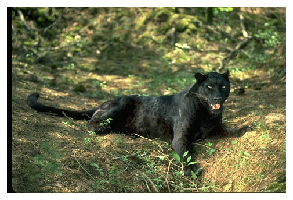

In [53]:
# plot original image
original = plt.imread("original_png/0064.png")
fig = plt.figure(figsize=(5,5))
plt.imshow(original)
plt.grid(False)
plt.axis('off')

(321, 481, 3)

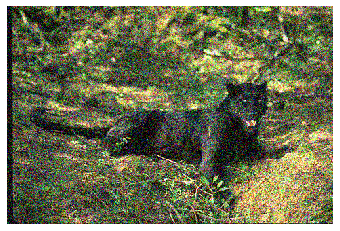

In [55]:
# plot noisy image
noisy = plt.imread("noisy50/0064.png")
plt.imshow(noisy)
plt.grid(False)
plt.axis('off')
noisy.shape

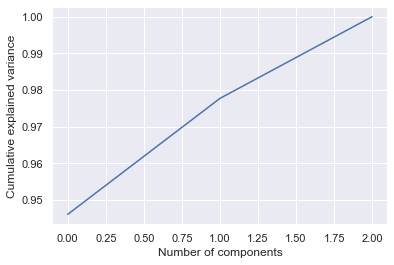

In [7]:
# plotting the number of components which can capture most of the variance in the data
pca = PCA().fit(noisy.reshape(-1,3))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


14.938084393818256 19.152335076542602 0.35678895291402596 0.5842142449210438


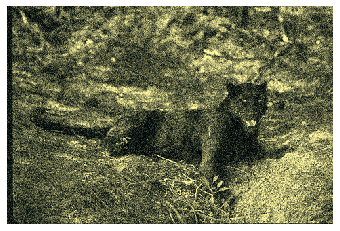

In [60]:
# DO PCA analysis for the noisy image
psnr1,psnr2,ssim1,ssim2,denoised = pca_simple_denoising_dataset(original,noisy)
plt.imshow(denoised)
plt.grid(False)
plt.axis('off')
print(psnr1,psnr2,ssim1,ssim2)

# PCA analysis in whole dataset

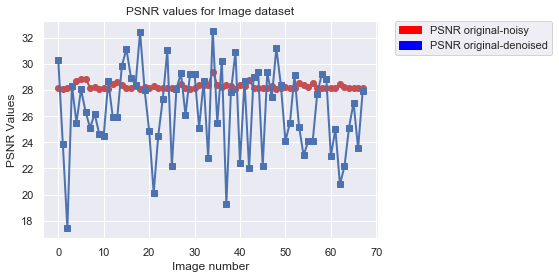

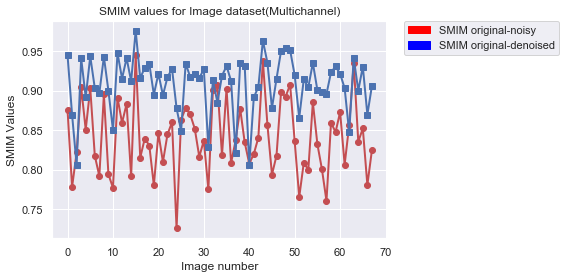

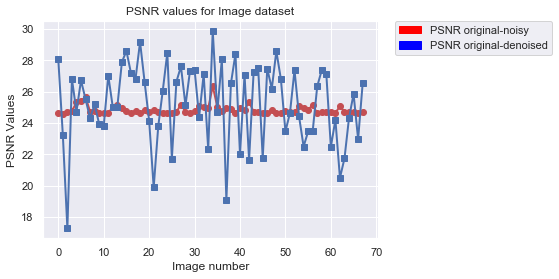

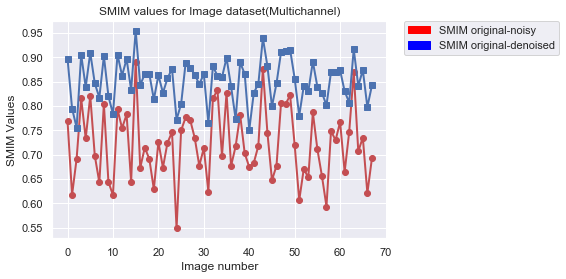

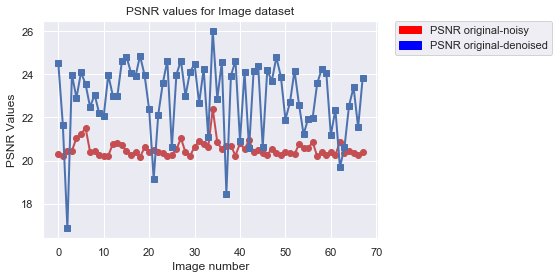

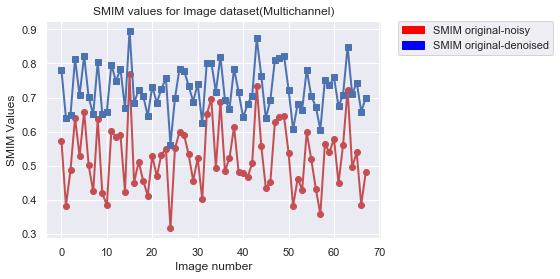

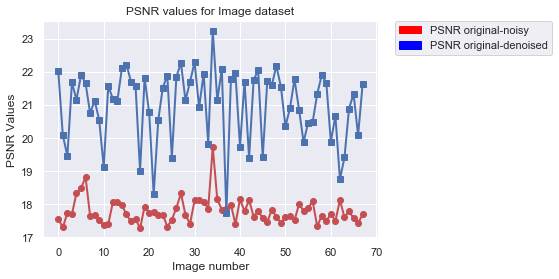

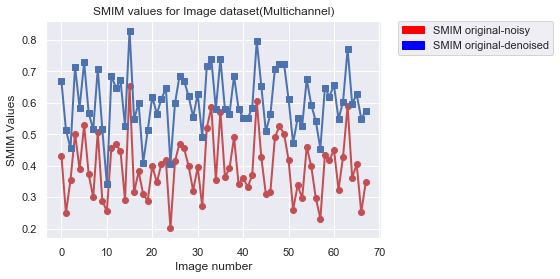

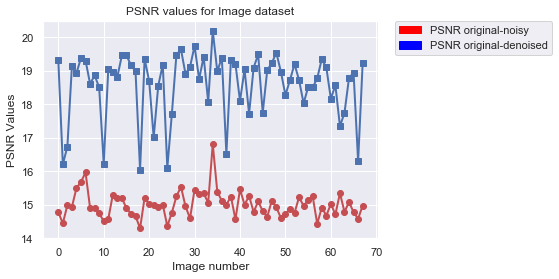

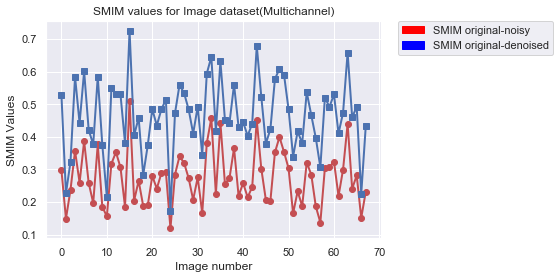

In [69]:
import glob
sigma = [10,15,25,35,50]
avg_psnr = []
avg_smim = []
for s in sigma:
    filenames_noisy = [img for img in glob.glob("noisy"+ str(s) +"/*.png")]
    filenames_original = [img for img in glob.glob("original_png/*.png")]
    images = []
    p1 = []
    p2 = []
    s1 =[]
    s2 = []
    i,j=0,0
    denoised_images = []
    while i<len(filenames_noisy) and j<len(filenames_original):
        original = plt.imread(filenames_original[j])
        noisy= plt.imread(filenames_noisy[i])
        psnr1,psnr2,sm1,sm2,denoised = pca_simple_denoising_dataset(original,noisy)
        #print(filenames_original[i],filenames_noisy[j],psnr1,psnr2)
        p1.append(psnr1)
        p2.append(psnr2)
        s1.append(sm1)
        s2.append(sm2)
        denoised_images.append(denoised)
        i+=1
        j+=1
    plot_graphs_all_images_psnr(p1,p2)
    plot_graphs_all_images_smim(s1,s2)
    avg_psnr.append((np.mean(p1),np.mean(p2)))
    avg_smim.append((np.mean(s1),np.mean(s2)))
   

In [70]:
# average psnr and smim values
print(avg_psnr)
print(avg_smim)

[(28.282814967820986, 26.469029884345595), (24.83123035505642, 25.237308141320266), (20.537621078588387, 22.93799433366067), (17.78690502241, 20.997853863765595), (15.002506590951942, 18.60284718457043)]
[(0.841940346956284, 0.909007589150991), (0.721481040102541, 0.8513834288106817), (0.5252336904679258, 0.7239287508994123), (0.39464145807083273, 0.6027696233315539), (0.2748505268717354, 0.46429759719548347)]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


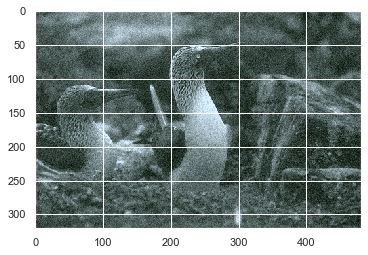

In [52]:
# Code to experiment on the data
import glob
images = ['0064.png','0045.png','0055.png','0003.png','0041.png','0047.png','0030.png','0028.png','0011.png']
for im in images:
    filenames_noisy = [img for img in glob.glob("noisy25"+ "/"+ str(im))]
    filenames_original = [img for img in glob.glob("original_png/"+str(im))]
    i,j=0,0
    while i<len(filenames_noisy) and j<len(filenames_original):
        original = plt.imread(filenames_original[j])
        plt.imshow(original)
        plt.savefig("/Users/gauravpande/Image-Denoising/assets/vanilla_pca/noise25/"+str(im.split(".")[0])+"_original.png")
        noisy= plt.imread(filenames_noisy[i])
        plt.imshow(noisy)
        plt.savefig("/Users/gauravpande/Image-Denoising/assets/vanilla_pca/noise25/"+str(im.split(".")[0])+"_noisy.png")
        psnr1,psnr2,denoised = pca_simple_denoising_dataset(original,noisy)
        #print(filenames_original[i],filenames_noisy[j],psnr1,psnr2)
        plt.imshow(denoised)
        plt.savefig("/Users/gauravpande/Image-Denoising/assets/vanilla_pca/noise25/"+str(im.split(".")[0])+"_denoised.png")
        i+=1
        j+=1
